In [1]:
# Smarter Circuits #
import sys
sys.path.append('../')


import imagePreprocessing as ip
import graphGeneration as gg
import cuircitGeneration as cg
import componentClassification as cc
import matplotlib.pyplot as plt
import cv2
import lib.utils as utils
import os
import numpy as np
import random
import string
import igraph
import copy

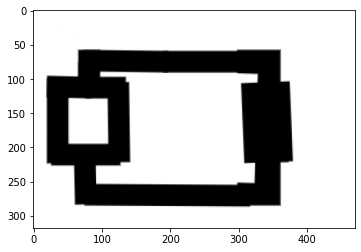

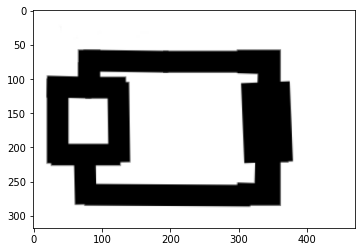

In [22]:
name = "6.png"

image = utils.loadImage(path="./../resources/testImages",name=name, resize=(450,None))

colorImage = utils.loadImage(path="./../resources/testImages",name=name, resize=(450,None), color=True)

#insert padding
s1 = np.full((len(image),10),255)
image = np.insert(image, [0], s1, axis=1)
image = np.insert(image, [len(image[0])], s1, axis=1)
s2 = np.full((10,len(image[0])),255)
image = np.insert(image, [0], s2, axis=0)
image = np.insert(image, [len(image)], s2, axis=0)

s1 = np.full((len(colorImage),10,3),255)

colorImage = np.insert(colorImage, [0], s1, axis=1)
colorImage = np.insert(colorImage, [len(colorImage[0])], s1, axis=1)
s2 = np.full((10,len(colorImage[0]),3),255)

colorImage = np.insert(colorImage, [0], s2, axis=0)
colorImage = np.insert(colorImage, [len(colorImage)], s2, axis=0)

plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(colorImage)

33


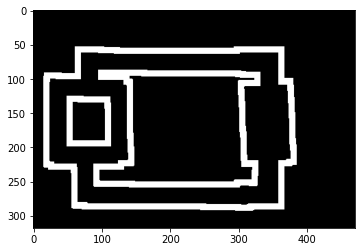

In [5]:
#get mean line thiknes
#start in left corner
#go to right corner

width = []
#(_,image) = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)
for x in range(0,len(image[0])):
    counter = 0
    for y in range(0,len(image)):
        if image[y][x] == 0:
            counter += 1
        if image[y][x] == 255:
            if not counter == 0:
                width.append(counter)
            counter = 0
width = list(filter(lambda x: x> 2,width))

widthSet = set(width)
widthDict = {}
for key in widthSet:
    widthDict[key] = width.count(key)

dicke = max(widthDict, key=widthDict.get)
print(dicke)

#image = cv2.Canny(image, 30, 100)
#kernel = np.ones((10,10),np.uint8)
#imagenew = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)

#plt.imshow(imagenew, cmap='gray')

In [29]:
img = 255-cv2.imread("./../resources/testImages/image.png",0)

(_,img) = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)

cv2.imshow("origninal",img)

## Detect mean line thicknes
width = []
for x in range(0,len(img[0])):
    counter = 0
    for y in range(0,len(img)):
        if img[y][x] == 255:
            counter += 1
        if img[y][x] == 0:
            if not counter == 0:
                width.append(counter)
            counter = 0
width = list(filter(lambda x: x> 2,width))

widthSet = set(width)
widthDict = {}
for key in widthSet:
    widthDict[key] = width.count(key)

thickness = max(widthDict, key=widthDict.get)
##end


#clean image 
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((int(thickness*0.5),int(thickness*0.5)),np.uint8))

#only get inductances
kernel = np.ones((thickness+15,thickness+15),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)

imi = cv2.absdiff(img.copy(),erosion.copy())

cv2.imshow("erosion",erosion)

cv2.imshow("test",imi)
cv2.waitKey(0)
cv2.destroyAllWindows()

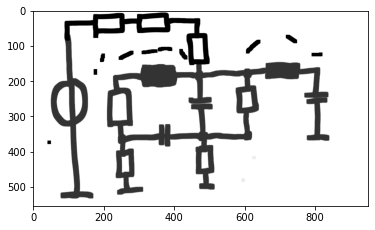

In [43]:
plt.imshow(erosion, cmap='gray')

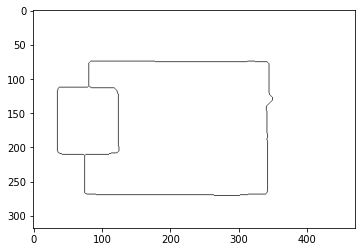

In [4]:
preprocessedImage = ip.preprocessImage(image)
utils.saveImage(name="preprocessed.png", image=preprocessedImage)

plt.imshow(preprocessedImage, cmap='gray')

In [5]:
#class_names = os.listdir('./../trainData')
#
#for class_name in class_names:
#    data = os.listdir('./trainData/{class_name}'.format(class_name=class_name))

def generateTrainData(boundingBoxes, image):
    print(boundingBoxes)
    counter = []
    for box in boundingBoxes:
        component = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        component = cv2.resize(component, (32,32), interpolation = cv2.INTER_AREA)
        #utils.saveImage(path='./../resources/trainData/')
        utils.saveImage(path='./../resources/trainData/', name="{i}.png".format(i=''.join(random.choice(string.ascii_lowercase) for i in range(10))), image=component)

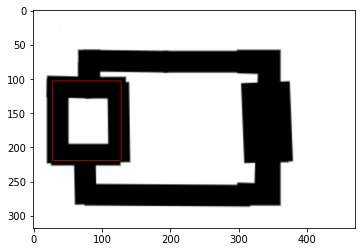

In [6]:
graph = gg.generateGraph(preprocessedImage)
components = gg.getComponents(graph, preprocessedImage)
bb = utils.fmap(lambda x: x[0],components)
#generateTrainData(bb, image)

def drawRect(image,boundingBox,color):
    corner1 = boundingBox[0]
    corner2 = boundingBox[1]
    startX = corner1[0]
    startY = corner1[1]

    endX = corner2[0]
    endY = corner2[1]

    for x in range(startX,endX):
        try:
            image[startY][x] = color
            image[endY][x] = color
        except:
            pass

    for y in range(startY,endY):
        try:
            image[y][startX] = color
            image[y][endX] = color
        except:
            pass

    return image


for comp in components:
    drawRect(colorImage,comp[0],(255,0,0))
#colorImage = cv2.cvtColor(255-colorImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorImage,interpolation="bilinear")

In [7]:
#igraphUnion = utils.convertToIgraph(graph)
#layout = igraphUnion.layout("large_graph") #"large_graph"
#igraph.plot(igraphUnion, layout=layout,bbox = (1000,1000))

In [8]:
cc.loadModel()

predictions = []

for comp in components:
    box = comp[0]
    matches = comp[1]
    buildingType = cc.predict(box,image)#[0]
    #rot = cc.predict(box,image)[1]
    predictions.append((box,matches,buildingType))#,rot))
print(len(predictions))

1


inductor -> blue
resistor -> green
capacitor -> red
ground -> purple


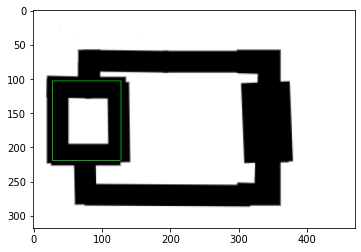

In [9]:
for i in range(0, len(predictions)):
    #colorImage = utils.drawArrow(colorImage,predictions[i][0],predictions[i][3],[255,0,0])
    if predictions[i][2] == "inductor":
        #predictions[i] = (predictions[i][0],predictions[i][1],'resistor')#,predictions[i][3])
        colorImage = utils.drawRect(colorImage,predictions[i][0],[255,0,0])
    elif predictions[i][2] == "resistor":
        colorImage = utils.drawRect(colorImage,predictions[i][0],[0,255,0])
    elif predictions[i][2] == "capacitor":
        colorImage = utils.drawRect(colorImage,predictions[i][0],[0,0,255])
    elif predictions[i][2] == "ground":
        colorImage = utils.drawRect(colorImage,predictions[i][0],[255,0,255])

print("inductor -> blue")
print("resistor -> green")
print("capacitor -> red")
print("ground -> purple")


utils.saveImage(name="boundingBoxes.png", image=colorImage, color=True)
colorImage = cv2.cvtColor(colorImage, cv2.COLOR_BGR2RGB)
plt.imshow(colorImage)

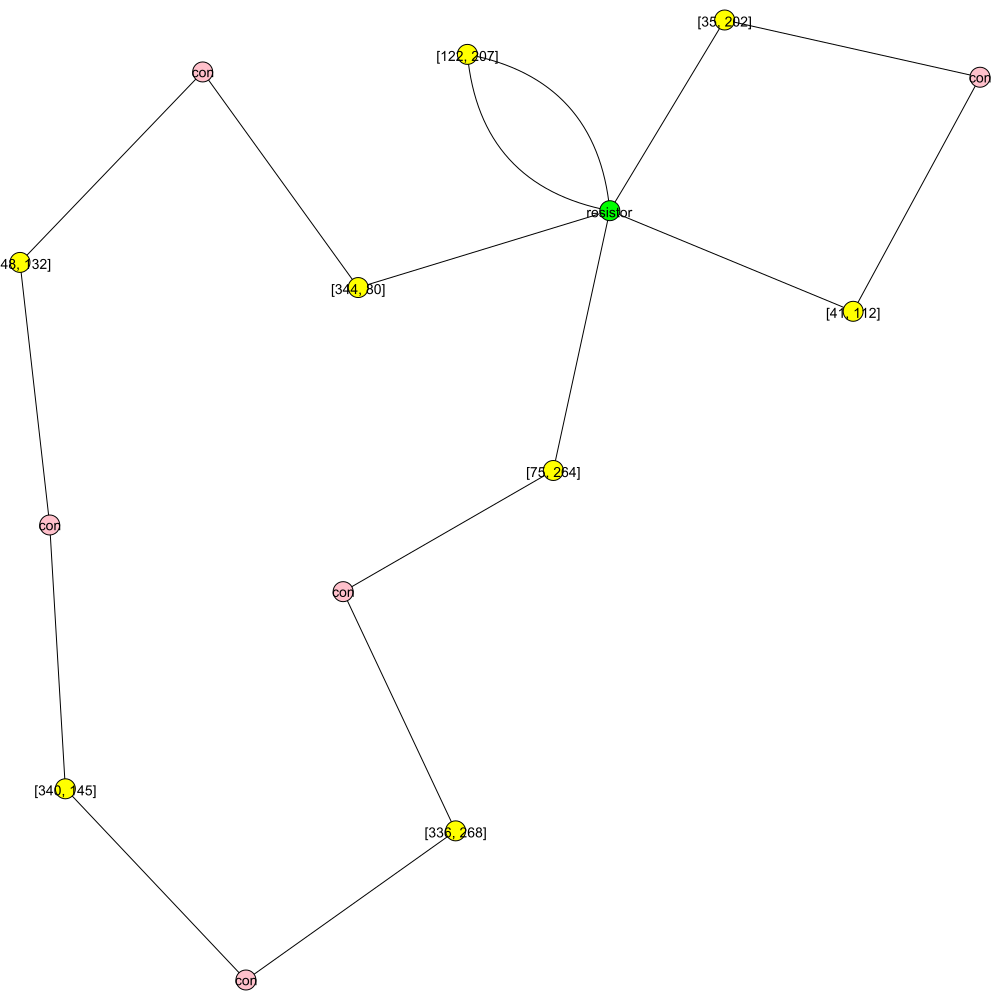

In [10]:
graph = cg.createLTSpiceFile(predictions,graph,"./out.asc")

igraphUnion = utils.convertToIgraph(graph)
layout = igraphUnion.layout("large_graph") #"large_graph"
igraph.plot(igraphUnion, layout=layout,bbox = (1000,1000))